# **Hand Identification System that identifies people from Hyperspectral hand images**

**Move to the directory of the notebook - only for Google Colab**

In [1]:
cd drive/MyDrive/Colab Notebooks/hyperspectral_hands/

/content/drive/MyDrive/Colab Notebooks/hyperspectral_hands


**Load Libraries**

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import scipy.io as sio
import matplotlib.pyplot as plt
from skimage import color, data, restoration
from sklearn.decomposition import PCA
from keras import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report

## **Show Hyperspectral Hand Images and Eigenvalues**

**Hyperspectral Hand Image band 10**

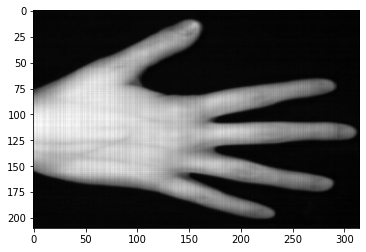

In [ ]:
# Load dataset
data_train = pd.read_csv('hands_train.csv')

img_path = "/content/drive/MyDrive/Colab Notebooks/hyperspectral_hands/users/dorsal/cubo001_1.mat"
image = sio.loadmat(img_path)
image = image['cubo']
image = np.transpose(image, (1, 2, 0))
image = image[45:255, 10:325, 10]

plt.imshow(image, cmap="gray") 
plt.show()

**Apply PCA to every user (each 1 image)**

In [ ]:
# Load data
data_train = pd.read_csv('hands_pca.csv')

# Apply PCA for each user
pca_results = []
for i, row in data_train.iterrows():
    img_path = "/content/drive/MyDrive/Colab Notebooks/hyperspectral_hands/users/dorsal/" + row['ImageName']
    img_tr = sio.loadmat(img_path)
    img_tr = img_tr['cubo']
    img = np.transpose(img_tr, (1, 2, 0))
    img = img[45:255, 10:325, :]
    spectral_data = img.reshape(256, -1)
    pca = PCA()
    pca.fit(spectral_data.T)
    pca_results.append(pca)

**Plot Eigenvalues for each user**

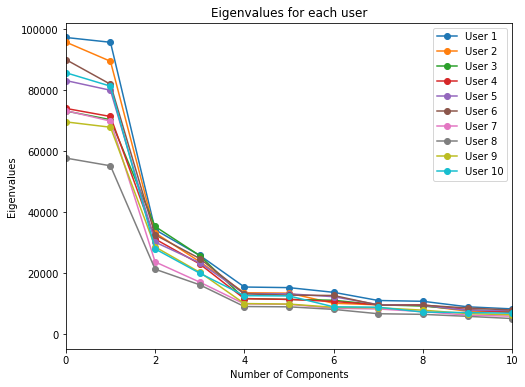

In [ ]:
# Plot eigenvalues for each user
plt.figure(figsize=(8, 6))
for i, pca in enumerate(pca_results):
    plt.plot(pca.explained_variance_, label=f'User {i+1}', marker='o', markevery=1)
plt.xlabel('Number of Components')
plt.ylabel('Eigenvalues')
plt.xlim(0, 10)  # set x-axis limits

plt.title("Eigenvalues for each user")

plt.legend()
plt.show()

**Apply PCA to the first 3 principal components**

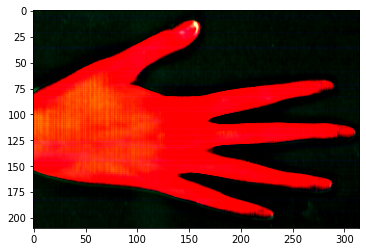

In [ ]:
# Load data
data_train = pd.read_csv('hands_train.csv')

img_path = "/content/drive/MyDrive/Colab Notebooks/hyperspectral_hands/users/dorsal/cubo001_1.mat"
img = sio.loadmat(img_path)
img = img['cubo']
img = np.transpose(img, (1, 2, 0))
img = img[45:255, 10:325, :]

# Normalisation
img = (img - np.min(img)) / (np.max(img) - np.min(img))

# Reshape to a 2D array
h, w, b = img.shape
img_reshaped = img.reshape((h*w, b))

# Apply PCA to reduce the dimensionality of the hyperspectral image
pca = PCA(n_components=3)
img_pca = pca.fit_transform(img_reshaped)

# Reshape PCA image back to the original shape
img_pca_reshaped = img_pca.reshape((h, w, 3))

plt.imshow(img_pca_reshaped, cmap="gray") 
plt.show()

**Plot the 3 channels after PCA for the first 3 principal components**

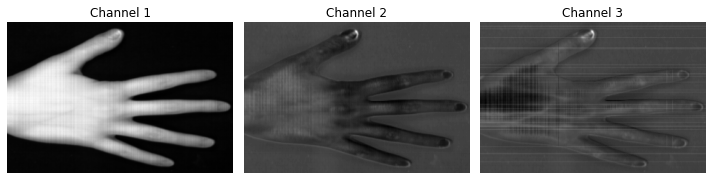

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
axs = axs.flatten()
for i in range(3):
    axs[i].imshow(img_pca_reshaped[:,:,i], cmap='gray')
    axs[i].set_title(f"Channel {i+1}")
    axs[i].axis('off')

plt.tight_layout()
plt.show()

# **Pre-Processing**

**Apply PCA to the first 3 principal components**

In [3]:
def preprocess_image(img_path):

  image = sio.loadmat(img_path)
  image = image['cubo']
  image = np.transpose(image, (2, 1, 0))
  image = image[45:255, 10:325, :]

  # Normalisation
  image = (image - np.min(image)) / (np.max(image) - np.min(image))

  # Reshape hyperspectral image to a 2D array
  h, w, b = image.shape
  img_reshaped = image.reshape((h*w, b))

  # Apply PCA to reduce the dimensionality of the hyperspectral image
  pca = PCA(n_components=3)
  img_pca = pca.fit_transform(img_reshaped)

  # Reshape PCA image back to the original shape
  output_img = img_pca.reshape((h, w, 3))

  return output_img

**Prepare the train and test data**

In [4]:
# Load datasets
train_ds = pd.read_csv('hands_train.csv')
test_ds = pd.read_csv('hands_test.csv')

# Prepare train data
train_data = []
for i, row in train_ds.iterrows():
    img_path = "/content/drive/MyDrive/Colab Notebooks/hyperspectral_hands/users/dorsal/" + row['ImageName']
    output_img = preprocess_image(img_path)
    train_data.append(output_img)

train_data = np.array(train_data)
train_labels = train_ds["ID"].values

# Prepare test data
test_data = []
for i, row in test_ds.iterrows():
    img_path = "/content/drive/MyDrive/Colab Notebooks/hyperspectral_hands/users/dorsal/" + row['ImageName']
    output_img = preprocess_image(img_path)
    test_data.append(output_img)

test_data = np.array(test_data)
test_labels = test_ds["ID"].values

**Split the train data into training and validation sets**

In [5]:
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.25, random_state=42)

**Model architecture**

In [6]:
# Load the VGG16 model
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(210,310,3))

# Freeze the layers
for layer in vgg_model.layers:
    layer.trainable = False

# Add the fully connected layers
model = Sequential()
model.add(vgg_model)
model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dense(11, activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])

# Display the model structure
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 9, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 27648)             0         
                                                                 
 dense (Dense)               (None, 4096)              113250304 
                                                                 
 dense_1 (Dense)             (None, 11)                45067     
                                                                 
Total params: 128,010,059
Trainable params: 113,295,371
Non-trainable params: 14,714,688
_________________________________________________________________


**Train model**

In [7]:
history = model.fit(train_data, train_labels, epochs=15, batch_size = 12, validation_data=(val_data, val_labels))

model.save('trained_model.h5')

Epoch 1/15
5/5 [==============================] - 6s 448ms/step - loss: 32.0867 - accuracy: 0.1500 - val_loss: 15.7915 - val_accuracy: 0.2500
Epoch 2/15
5/5 [==============================] - 1s 131ms/step - loss: 18.2383 - accuracy: 0.3333 - val_loss: 8.4222 - val_accuracy: 0.4500
Epoch 3/15
5/5 [==============================] - 1s 131ms/step - loss: 6.5854 - accuracy: 0.5500 - val_loss: 4.1258 - val_accuracy: 0.7500
Epoch 4/15
5/5 [==============================] - 1s 132ms/step - loss: 4.0495 - accuracy: 0.7500 - val_loss: 5.5775 - val_accuracy: 0.7000
Epoch 5/15
5/5 [==============================] - 1s 132ms/step - loss: 1.8056 - accuracy: 0.8333 - val_loss: 0.3574 - val_accuracy: 0.9000
Epoch 6/15
5/5 [==============================] - 1s 132ms/step - loss: 0.6529 - accuracy: 0.9333 - val_loss: 0.0646 - val_accuracy: 0.9500
Epoch 7/15
5/5 [==============================] - 1s 131ms/step - loss: 0.1517 - accuracy: 0.9833 - val_loss: 0.0498 - val_accuracy: 0.9500
Epoch 8/15
5/5 [=

**Plot learning curves**

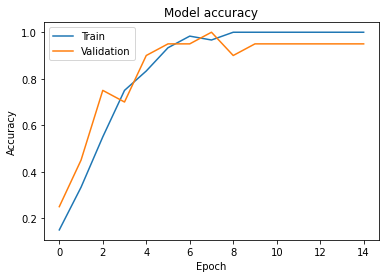

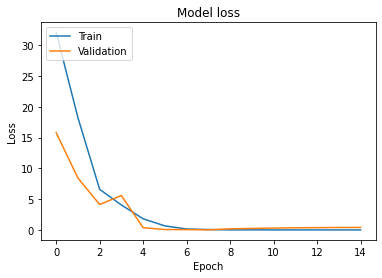

In [8]:
# Plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Evaluation Metrics**

In [9]:
# Predict the labels for test data
predictions = model.predict(test_data)
predicted_labels = np.argmax(predictions, axis=1)

# Calculate loss
test_loss, test_accu = model.evaluate(test_data, test_labels) 
print('Accuracy:', test_accu)
print('Loss:', test_loss)

# Calculate precision, recall, and F1-score for each class
from sklearn.metrics import classification_report
target_names = [f"ID_{i}" for i in range(10)]
report = classification_report(test_labels, predicted_labels, target_names=target_names)
print(report)

1/1 [==============================] - 0s 152ms/step - loss: 0.8552 - accuracy: 0.8500
Accuracy: 0.8500000238418579
Loss: 0.8551972508430481
              precision    recall  f1-score   support

        ID_0       0.00      0.00      0.00         2
        ID_1       1.00      0.50      0.67         2
        ID_2       0.67      1.00      0.80         2
        ID_3       1.00      1.00      1.00         2
        ID_4       1.00      1.00      1.00         2
        ID_5       1.00      1.00      1.00         2
        ID_6       1.00      1.00      1.00         2
        ID_7       0.67      1.00      0.80         2
        ID_8       0.67      1.00      0.80         2
        ID_9       1.00      1.00      1.00         2

    accuracy                           0.85        20
   macro avg       0.80      0.85      0.81        20
weighted avg       0.80      0.85      0.81        20



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
